In [1]:
%load_ext autoreload

import sys
import copy
import os
sys.path.append("/home/lauro/code/msc-thesis/svgd/kernel_learning")
import json
import collections
import itertools
from functools import partial
import importlib

import numpy as onp
from jax.config import config
config.update("jax_debug_nans", False)
# config.update("jax_log_compiles", True)
# config.update("jax_enable_x64", True)

from tqdm import tqdm

import jax.numpy as np
from jax import grad, jit, vmap, random, lax, jacfwd, value_and_grad
from jax import lax
from jax.ops import index_update, index
import optax
import matplotlib.pyplot as plt

import numpy as onp
import jax
import pandas as pd
import haiku as hk
import ot
import seaborn as sns

import utils
import metrics
import time
import plot
import stein
import kernels
import distributions
import nets
import kernel_learning
import models
import flows

from jax.experimental import optimizers

key = random.PRNGKey(0)
key, subkey = random.split(key)

from jax.scipy.stats import norm

sns.set_theme()

/home/lauro/.virtualenvs/msc-thesis/lib/python3.8/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


# Test general gradient estimator
* generate sets of samples from different distributions
* train gradient approximator on all those sets
* see how well it does

In [84]:
class SetEmbedding(hk.Module):
    def __init__(self, phi_sizes, w_init=hk.initializers.VarianceScaling(2.0), name=None):
        """embed_size: integer, output dimension"""
        super().__init__(name=name)
        self.sizes = phi_sizes
        self.w_init = w_init

    def __call__(self, x):
        """x is a set of shape (n, ...), where n
        is the number of element in the set.

        Computes:
        x1, ..., xn --> phi(x1), ..., phi(xn) --> mean(...)
        """
        n = x.shape[0]
        phi = hk.nets.MLP(output_sizes=self.sizes,
                          w_init=self.w_init,
                          activation=jax.nn.swish,
                          activate_final=True)

        set_embedding = hk.Sequential([
            phi,
            partial(np.mean, axis=0),
        ])
        return set_embedding(x)

In [106]:
# set up model
class Hypernetwork(hk.Module):
    def __init__(self,
                 sizes,
                 output_size: int,
                 unravel_fun: callable = lambda x: x,
                 name: str = None):
        """
        init_x should have shape (n, d)
        """
        super().__init__(name=name)
        self.sizes = sizes
#         self.w_init = hk.initializers.VarianceScaling(scale=2.0)
        self.w_init = hk.initializers.Orthogonal(scale=2.)
        self.unravel_fun = unravel_fun
        self.output_size = output_size

    def __call__(self, x):
        """args: a batch of samples, shaped (n, d)"""
        set_embedding = SetEmbedding(self.sizes, w_init=self.w_init)
        net = hk.Sequential([
            set_embedding,
            jax.nn.swish,
            hk.Linear(32),
            jax.nn.swish,
            hk.Linear(self.output_size),
        ])
        return self.unravel_fun(net(x))


# Mesa net
field = hk.transform(lambda x: hk.nets.MLP([8, 8, 8, 2],
                                           w_init=hk.initializers.VarianceScaling(scale=2.0),
                                           activation=jax.nn.swish,
                                           with_bias=False)(x))

x = np.ones((5, 2))
field_params = field.init(subkey, x)
field_params_flat, unravel = jax.flatten_util.ravel_pytree(field_params)


# Hypernet
output_size=field_params_flat.shape[0]
phi_sizes = [32, 32, 32]
hypernet = hk.transform(lambda samples: Hypernetwork(sizes=phi_sizes,
                                                     output_size=output_size,
                                                     unravel_fun=unravel)(samples))
key, subkey = random.split(key)
params = hypernet.init(subkey, x)

def get_field(particles, params):
    norm = nets.get_norm(particles)
#     norm = lambda x: x
    field_params = hypernet.apply(params, None, particles)
    def v(x):
        return field.apply(field_params, None, norm(x))
    return v

In [107]:
jax.flatten_util.ravel_pytree(params)[0].shape

(8544,)

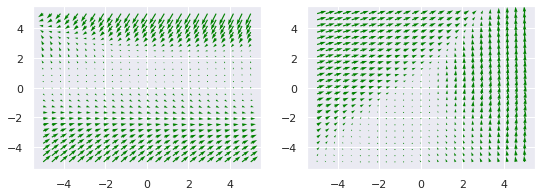

In [108]:
%matplotlib inline

# plot output
fig, axs = plt.subplots(1, 2, figsize=[9, 3])
axs = axs.flatten()
particles = distributions.Gaussian([0, 1], [15, 2]).sample(100)
v_init = get_field(particles, params)
plot.plot_gradient_field(v_init, axs[0])

# compare:
usual_v_init = lambda x: field.apply(field_params, None, x)
plot.plot_gradient_field(usual_v_init, axs[1])

### Architecture 2

In [117]:
class BatchedField(hk.Module):
    def __init__(self, sizes, name=None):
        super().__init__(name=name)
        self.embedding_sizes = sizes # phi sizes
        self.w_init = hk.initializers.VarianceScaling(scale=2.0)

    def __call__(self, x, all_x):
        """args:
        x: shape (d,)
        all_x: a batch of samples, shaped (n, d)"""
        n, d = all_x.shape
        set_embedding = SetEmbedding(self.embedding_sizes, w_init=self.w_init)
        mlp = hk.nets.MLP([32, 32, 32], w_init=self.w_init, activation=jax.nn.swish)
        con = np.concatenate([set_embedding(all_x), mlp(x)])
        final = hk.Sequential([
            jax.nn.swish,
            hk.Linear(32, w_init=self.w_init),
            jax.nn.swish,
            hk.Linear(d, w_init=self.w_init),
        ])
        return final(con)


batched_field = hk.transform(lambda *args: BatchedField([32, 32])(*args))
all_x = np.ones((5, 2))
params = batched_field.init(subkey, all_x[0], all_x)

def get_field(particles, params):
    norm = nets.get_norm(particles)
    def v(x):
        return batched_field.apply(params, None, norm(x), particles)
    return v

### Architecture 3

In [178]:
class BatchedField(hk.Module):
    """TOO EXPENSIVE"""
    def __init__(self, sizes, name=None):
        super().__init__(name=name)
        self.sizes = sizes
        self.w_init = hk.initializers.VarianceScaling(scale=2.0)

    def __call__(self, x):
        """args:
        x: a batch of samples, shaped (n, d)"""
        n, d = x.shape
        norm = nets.get_norm(x)
        set_embedding = SetEmbedding(self.sizes, w_init=self.w_init) # shape s
        mlp = hk.nets.MLP([32, 32, self.sizes[-1]], w_init=self.w_init, activation=jax.nn.swish) # shape (n, s)
        net = hk.Sequential([
            jax.nn.swish,
            hk.Linear(32, w_init=self.w_init),
            jax.nn.swish,
            hk.Linear(d, w_init=self.w_init),
        ])
        # vmap(norm)(x)
        mul = mlp(x) * set_embedding(x) # shape (n, s)
        return net(mul)


batched_field = hk.transform(lambda *args: BatchedField([32, 32])(*args))
all_x = np.ones((5, 2))
params = batched_field.init(subkey, all_x)

def get_field(particles, params):
#     norm = nets.get_norm(particles)
    def v(x):
        all_x = np.vstack([particles, x])
        field = batched_field.apply(params, None, all_x)
        return field[-1]
    return v

In [179]:
f = get_field(all_x, params)
x = np.array([-1, 2.])
f(x)

DeviceArray([0.47267747, 0.08386485], dtype=float32)

In [181]:
jax.flatten_util.ravel_pytree(params)[0].shape

(4482,)

## Setup

In [171]:
# set up target
target = distributions.Gaussian([0, 0], 1)
target_logp = target.logpdf
def get_v(logq: callable):
    def v(x):
        return grad(logq)(x) - grad(target_logp)(x)
    return v


def loss_fn(params, particles):
    f = utils.negative(get_field(particles, params))
    stein_discrepancy = stein.stein_discrepancy(particles, target_logp, f)
    l2_f_sq = utils.l2_norm_squared(particles, f)
    loss = -stein_discrepancy + 1/2 * l2_f_sq

    aux = [loss, stein_discrepancy, l2_f_sq]
    return loss, aux


def compute_loss(samples, v):
    f = utils.negative(v)
    sd = stein.stein_discrepancy(samples, target_logp, f)
    return -sd + 1/2 * utils.l2_norm_squared(samples, f)

@partial(jit, static_argnums=0)
def get_true_loss(dist, key):
    true_v = get_v(dist.logpdf)
    samples = dist.sample(1000, key)
    return compute_loss(samples, true_v)


@partial(jit, static_argnums=(1,2))
def true_stein_discrepancy(particles, logq, f):
    stein_discrepancy = np.mean(vmap(
        lambda x: np.dot(f(x), grad(target_logp)(x) - grad(logq)(x))
    )(particles), axis=0)
    return stein_discrepancy

In [172]:
def naive_loss(dist, key):
    """SD(log p times lambda)"""
    samples = dist.sample(1000, key)
    sd_logq = true_stein_discrepancy(samples, dist.logpdf, grad(target_logp))
    l2 = utils.l2_norm_squared(samples, grad(target_logp))
    return -sd_logq**2 / l2 / 2

/home/lauro/code/msc-thesis/svgd/kernel_learning/plot.py:201: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  return ax.pcolormesh(*meshgrid, cmap=cmap, **kwargs)


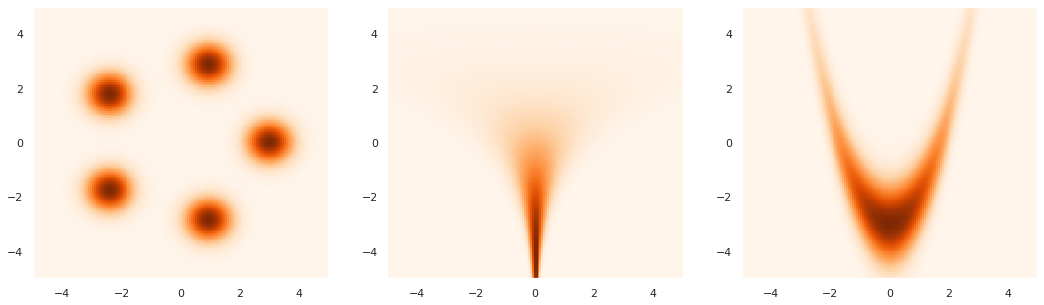

In [173]:
# test distributions
# all of them should be plottable in (-5, 5)
# (these are the ones we sample from; target is fixed at gaussian)

means = np.array([np.exp(2j*np.pi*x) for x in np.linspace(0, 1, 6)[:-1]])
means = np.column_stack((means.real,means.imag))*3
mix = distributions.GaussianMixture(means, .3, np.ones(5))

ring = distributions.Ring(3, .05)
funnel, _ = distributions.funnel.get()
banana = distributions.Banana([0, -3], [2, 1])
squiggle = distributions.Squiggle([0, 0], [2, .1])
# dists = (mix, funnel, banana)
dist_dict = {
    "mix": mix,
    "funnel": funnel,
    "banana": banana,
}

key, subkey  = random.split(key)
true_losses = [get_true_loss(dist, subkey) for dist in dist_dict.values()]
naive_losses = [naive_loss(dist, subkey) for dist in dist_dict.values()]
true_sds = [true_stein_discrepancy(dist.sample(1000), dist.logpdf, utils.negative(get_v(dist.logpdf))) for dist in dist_dict.values()]

fig, axs = plt.subplots(1, 3, figsize=[18, 5])
axs = axs.flatten()
for ax, dist in zip(axs, dist_dict.values()):
    plot.plot_fun_2d(dist.pdf, ax=ax)

In [174]:
def generator(key):
    for name, dist in itertools.cycle(dist_dict.items()):
        key, subkey = random.split(key)
        yield name, dist.sample(1000, key=subkey)
gen = generator(subkey)

In [175]:
# optimizer
opt = optax.adam(1e-4)
opt_state = opt.init(params)

@jit
def step(params, opt_state, samples):
    grads, aux = grad(loss_fn, has_aux=True)(params, samples)
    grads, opt_state = opt.update(grads, opt_state)
    params = optax.apply_updates(params, grads)
    return params, opt_state, aux

In [176]:
losses = {}
sds = {}

In [177]:
for _ in tqdm(range(1500)):
    name, samples = next(gen)
    params, opt_state, aux = step(params, opt_state, samples)
    loss, sd, l2 = aux
    metrics.append_to_log(losses, {name: loss})
    metrics.append_to_log(sds, {name: sd})

  1%|          | 13/1500 [02:37<5:00:57, 12.14s/it]


KeyboardInterrupt: 

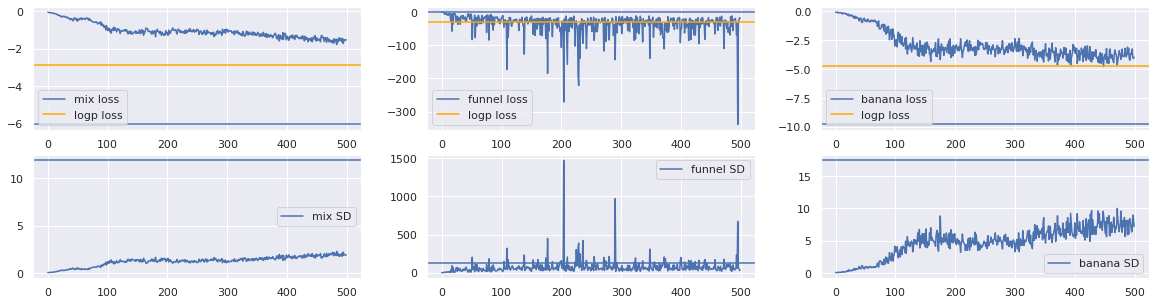

In [116]:
%matplotlib inline
fig, axs = plt.subplots(2, 3, figsize=[20, 5])

for (k, v), true_loss, naive_loss, ax in zip(losses.items(), true_losses, naive_losses, axs[0]):
    ax.plot(v, label=f"{k} loss")
    ax.axhline(true_loss)
    ax.axhline(naive_loss, label="logp loss", color="orange")
    ax.legend()

for (k, v), true_sd, ax in zip(sds.items(), true_sds, axs[1]):
    ax.plot(v, label=f"{k} SD")
    ax.axhline(true_sd)
    ax.legend()

In [51]:
dist = dists[3]
key, subkey = random.split(key)
samples = dist.sample(1000, subkey)
true_v = get_v(dist.logpdf)
learned_v = get_field(samples, params)
true_loss = compute_loss(samples, true_v)
loss = compute_loss(samples, learned_v)

In [21]:
# hypernet.apply(params, None, samples)

# Plot learned field

In [52]:
def plot_dist_index(ind):
    dist = dists[ind]
    samples = dist.sample(1000)
    v = get_field(samples, params)
    true_v = get_v(dist.logpdf)

    fig, axs = plt.subplots(1, 2, figsize=[12, 5])
    plot.plot_fun_2d(dist.pdf, ax=axs[0])
    plot.plot_gradient_field(v, axs[0])

    plot.plot_fun_2d(dist.pdf, ax=axs[1])
    plot.plot_gradient_field(vmap(true_v), axs[1])

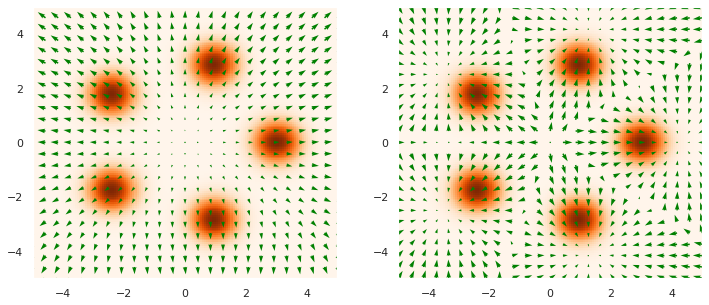

In [56]:
plot_dist_index(0)

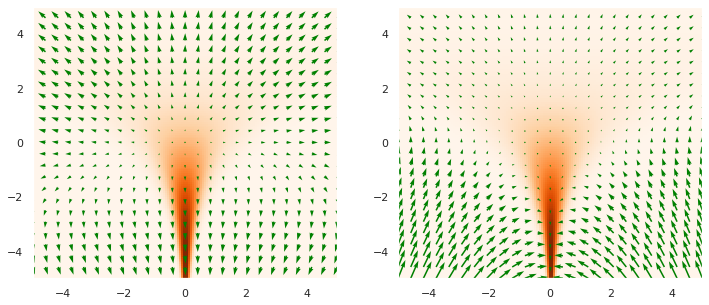

In [57]:
plot_dist_index(1)

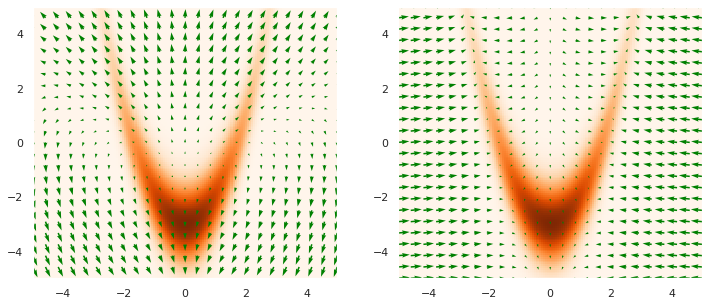

In [58]:
plot_dist_index(2)

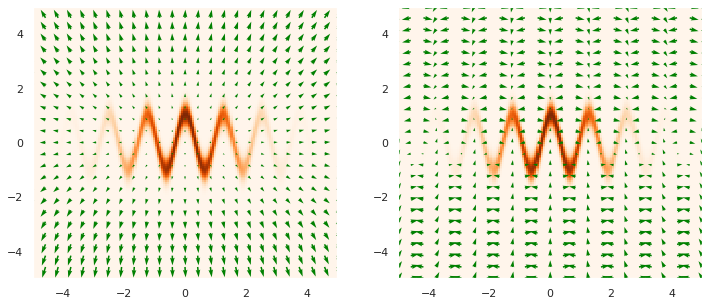

In [59]:
plot_dist_index(3)